# Cats and Dogs image classification
[Flask app example](https://github.com/amitrajitbose/cat-v-dog-classifier-pytorch)

# 0. Getting the data
The dataset can be downloaded from the [offical Kaggle competition page](https://www.kaggle.com/c/dogs-vs-cats/data). Once you have downloaded and extracted the data, the file structure should look like this:

```
dogs-vs-cats
-- train
---- cat.1.jpg
---- dog.1.jpg
---- ...
-- test
---- 1.jpg
---- 2.jpg
---- ...
```

### Create seperate cat and dog folders
The test set has no labels, so we will leave that as is. However, we want to group all cat and dog images into seperate folders within `train` to fit with format expected by the `torchvision.datasets.ImageFolder` class.

Within the downloaded data folder, add the following new folders:
  - train/cat
  - train/dog
  - val/cat
  - val/dog

In [1]:
import os, re, shutil
from tqdm.notebook import tqdm

data_dir = './dogs-vs-cats'
train_dir = data_dir+'/train'
train_dogs_dir = train_dir + '/dog'
train_cats_dir = train_dir + '/cat'
val_dir = data_dir+'/val'
val_dogs_dir = val_dir + '/dog'
val_cats_dir = val_dir + '/cat'

for im_dir in [train_dogs_dir, train_cats_dir, val_dir, val_dogs_dir, val_cats_dir]:
    if not os.path.exists(im_dir):
        os.makedirs(im_dir)

Your folder should now be structured as follows:

```
dogs-vs-cats
-- train
---- cat
------ cat.1.jpg
----dog
---- dog.1.jpg
-- val
---- cat
----dog
-- test
---- 1.jpg
---- 2.jpg
---- ...
```

### Move images into folders

In [2]:
files = os.listdir(train_dir)

# move all train cat images to cats folder, dog images to dogs folder
for f in tqdm(files):
    if 'cat' in f and 'jpg' in f:
        shutil.move(f'{train_dir}/{f}', train_cats_dir)
    elif 'dog' in f and 'jpg' in f:
        shutil.move(f'{train_dir}/{f}', train_dogs_dir)

Finally, move some images into the validation folder:

In [3]:
files = os.listdir(train_dogs_dir)
for f in tqdm(files):
    if re.search("5\d\d\d", f):
        shutil.move(f'{train_dogs_dir}/{f}', val_dogs_dir)
        
files = os.listdir(train_cats_dir)
for f in tqdm(files):
    if re.search("5\d\d\d", f):
        shutil.move(f'{train_cats_dir}/{f}', val_cats_dir)

Alternatively, another version of this dataset has been made available by Microsoft and is available [here](https://www.microsoft.com/en-us/download/details.aspx?id=54765). The code below can be used to download and unzip the data into your current directory.
> Note: the code will need to be adapted to work with the slightly different file structure of this version

```python
import zipfile, os, shutil
from urllib.request import urlopen

# stable link for dataset
url = 'https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/'
filename = 'kagglecatsanddogs_3367a.zip'

# download zip file from link
print('downloading and saving dataset from Microsoft stable link...')
downloaded = urlopen(url + filename)
buf = downloaded.read()

# save file and extract contents
with open(filename, 'wb') as f:
    f.write(buf)
    
print('unzipping contents')
with zipfile.ZipFile(filename) as zip:
    zip.extractall('.')

# remove zip file from directory
print('deleting zip file')
os.remove('kagglecatsanddogs_3367a.zip')

# free up some memory
del downloaded, buf
```

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import torch 
from torch.utils.data import DataLoader
from torch import nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms, models

### Check if host machine has GPU available

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


## Load Images
#### Apply transforms
Most of the pretrained models require the input to be 224x224 images. Also, we'll need to match the normalization used when the models were trained. Each color channel was normalized separately, the means are [0.485, 0.456, 0.406] and the standard deviations are [0.229, 0.224, 0.225].

```python
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize(255),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])
```

In [3]:
data_dir = 'PetImages'

image_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.ColorJitter(),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.Resize(128),
    transforms.ToTensor()
])

data = datasets.ImageFolder(data_dir, transform=image_transforms)

dataloader = torch.utils.data.DataLoader(data, batch_size=64, shuffle=True)

In [4]:
inputs, labels = next(iter(dataloader))

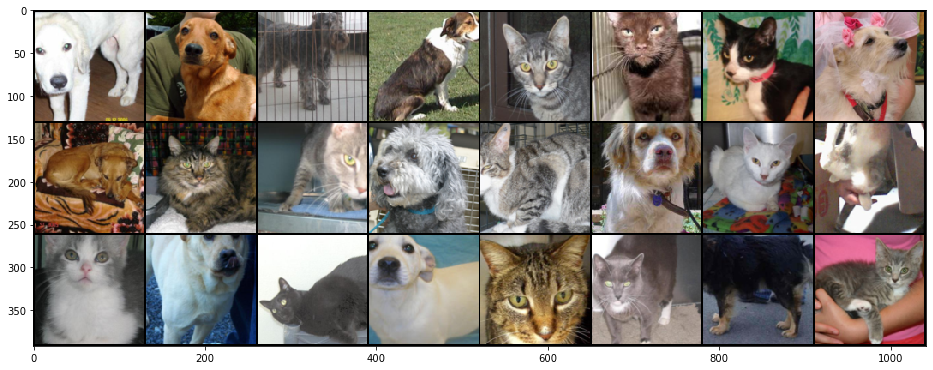

In [5]:
plt.figure(figsize=(16,24))
grid_imgs = torchvision.utils.make_grid(inputs[:24])
np_grid_imgs = grid_imgs.numpy()
# in tensor, image is (batch, width, height), so you have to transpose it to (width, height, batch) in numpy to show it.
plt.imshow(np.transpose(np_grid_imgs, (1,2,0)))

In [6]:
# load pre-trained densemodel model
model = torchvision.models.densenet121(pretrained=True)

# freeze parameters so we don't backprop through them
for param in model.parameters():
    param.requires_grad = False

### Replace the head of the model

In [7]:
# ensure the new head fits onto the existing body
num_ftrs = model.classifier.in_features
# define architecture of classifier head
classifier = nn.Sequential(
    nn.Linear(num_ftrs, 512),
    nn.ReLU(),
    nn.Linear(512,256),
    nn.ReLU(),
    nn.Linear(256, 2),
    nn.LogSoftmax(dim=-1)
)

# update the head on pretrained model
model.classifier = classifier

In [8]:
model = model.to(device)
criterion = nn.NLLLoss()
optimizer = torch.optim.Adam(model.classifier.parameters(), lr=.003)

In [9]:
epochs = 3
losses = []
for epoch in range(epochs):
    
    # turns on dropout
    model.train()
    
    batch = 1
    running_loss = 0.0
    for inputs, labels in tqdm(dataloader):
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        losses.append(running_loss / batch)
        if batch % 10 == 0:
            print(f'Batch {batch} loss: {running_loss / batch:.3f}')
        if batch == 50:
            print(f'Epoch {epoch + 1} loss: {running_loss / batch:.3f}')
            break
        batch += 1

print('Finished Training')

Batch 10 loss: 0.831
Batch 20 loss: 0.559
Batch 30 loss: 0.445


C:\Users\jamesl\AppData\Local\Continuum\anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 32 bytes but only got 0. Skipping tag 270
  " Skipping tag %s" % (size, len(data), tag)
C:\Users\jamesl\AppData\Local\Continuum\anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag)
C:\Users\jamesl\AppData\Local\Continuum\anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag)
C:\Users\jamesl\AppData\Local\Continuum\anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag)
C:\Users\jamesl\AppData\Loc

Batch 40 loss: 0.376
Batch 50 loss: 0.333
Epoch 1 loss: 0.333


Batch 10 loss: 0.175
Batch 20 loss: 0.172
Batch 30 loss: 0.177
Batch 40 loss: 0.172
Batch 50 loss: 0.161
Epoch 2 loss: 0.161


Batch 10 loss: 0.182
Batch 20 loss: 0.183
Batch 30 loss: 0.173
Batch 40 loss: 0.173
Batch 50 loss: 0.167
Epoch 3 loss: 0.167
Finished Training


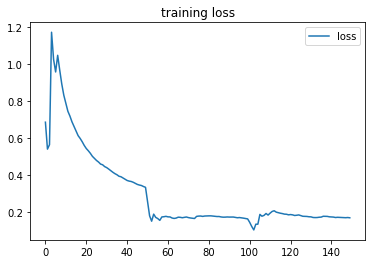

In [11]:
plt.plot(losses, label='loss')
plt.legend()
plt.title('training loss')
plt.show()

## Sample some test images and show predicted labels
**ToDo:**
  - use test images

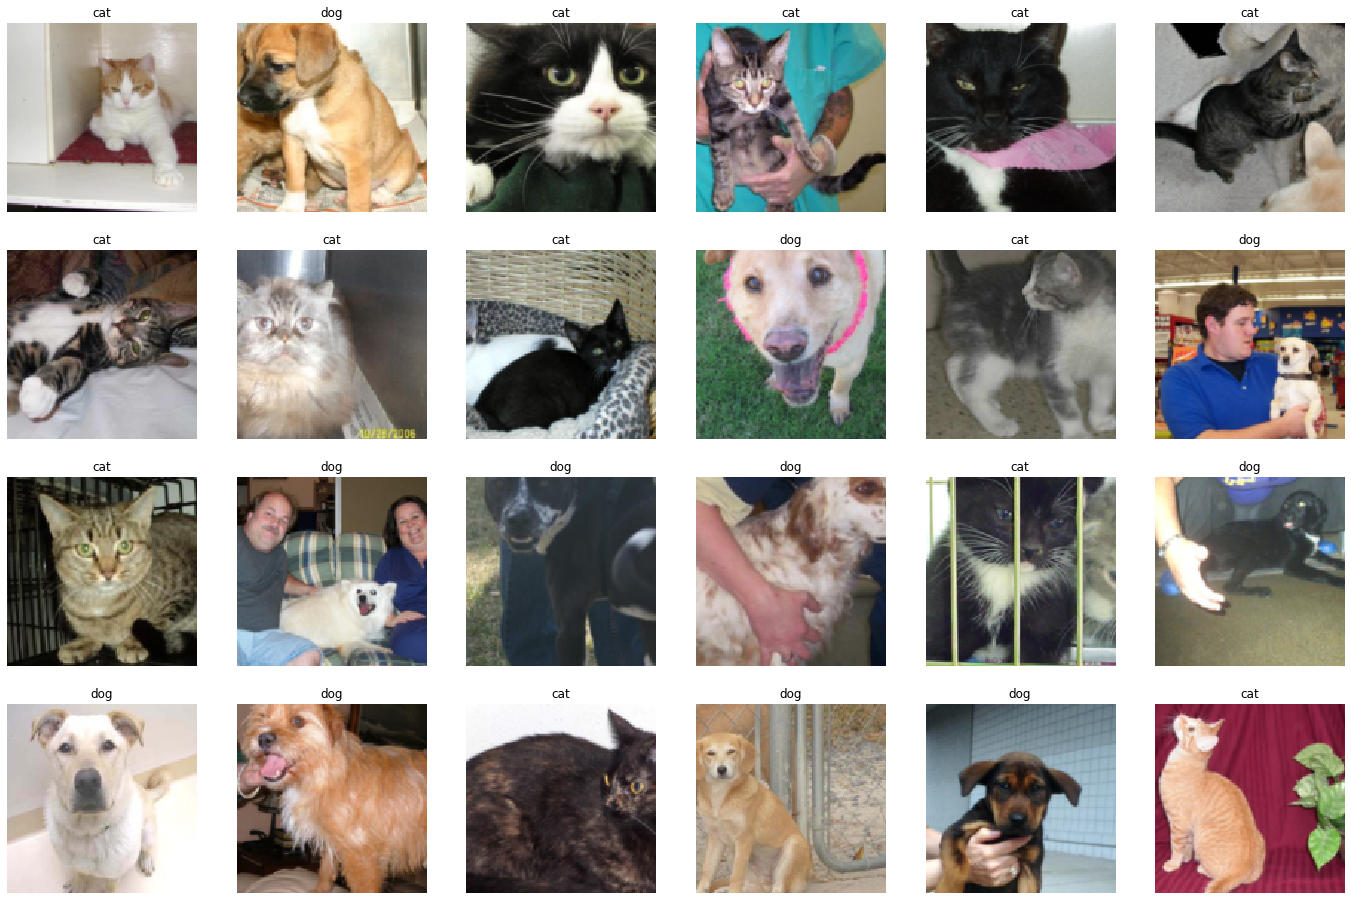

In [12]:
samples, _ = iter(dataloader).next()  # ToDo: change to test images
samples = samples.to(device)
output = model(samples[:24])
pred = torch.argmax(output, dim=1)
pred = [p.item() for p in pred]
ad = {0:'cat', 1:'dog'}

fig = plt.figure(figsize=(24, 16))
fig.tight_layout()
for num, sample in enumerate(samples[:24]):
    plt.subplot(4,6,num+1)
    plt.title(ad[pred[num]])
    plt.axis('off')
    sample = sample.cpu().numpy()
    plt.imshow(np.transpose(sample, (1,2,0)))